In [32]:
import numpy

In [33]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [34]:
data = pd.read_csv('almostblue.txt', sep=" ", header=None, nrows=1000000)

In [35]:
data

,0
0,-0.000015
1,-0.000015
2,-0.000031
3,-0.000015
4,-0.000015
5,-0.000031
6,-0.000031
7,-0.000046
8,-0.000031
9,-0.000031


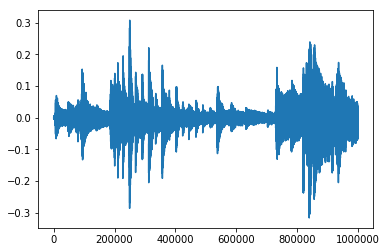

In [36]:
values = data.values
pyplot.figure()
pyplot.plot(values)
pyplot.show()

In [37]:
# convert series to supervised learning
# inspired from https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [38]:
# load dataset
values = data.values
# integer encode direction
encoder = LabelEncoder()
values[0] = encoder.fit_transform(values[0])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.506927  0.506903
2   0.506903  0.506878
3   0.506878  0.506903
4   0.506903  0.506903
5   0.506903  0.506878


In [39]:
# split into train and test sets 90-10
values = reframed.values
n_train = 900000
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((900000, 1, 1), (900000,), (99999, 1, 1), (99999,))


Train on 900000 samples, validate on 99999 samples
Epoch 1/50
 - 91s - loss: 0.0071 - val_loss: 0.0050
Epoch 2/50
 - 77s - loss: 0.0044 - val_loss: 0.0048
Epoch 3/50
 - 79s - loss: 0.0044 - val_loss: 0.0044
Epoch 4/50
 - 82s - loss: 0.0044 - val_loss: 0.0044
Epoch 5/50
 - 78s - loss: 0.0043 - val_loss: 0.0041
Epoch 6/50
 - 86s - loss: 0.0043 - val_loss: 0.0041
Epoch 7/50
 - 72s - loss: 0.0043 - val_loss: 0.0040
Epoch 8/50
 - 81s - loss: 0.0043 - val_loss: 0.0040
Epoch 9/50
 - 76s - loss: 0.0043 - val_loss: 0.0040
Epoch 10/50
 - 78s - loss: 0.0043 - val_loss: 0.0037
Epoch 11/50
 - 89s - loss: 0.0043 - val_loss: 0.0037
Epoch 12/50
 - 91s - loss: 0.0043 - val_loss: 0.0035
Epoch 13/50
 - 80s - loss: 0.0043 - val_loss: 0.0036
Epoch 14/50
 - 83s - loss: 0.0043 - val_loss: 0.0036
Epoch 15/50
 - 77s - loss: 0.0043 - val_loss: 0.0036
Epoch 16/50
 - 83s - loss: 0.0043 - val_loss: 0.0034
Epoch 17/50
 - 105s - loss: 0.0043 - val_loss: 0.0035
Epoch 18/50
 - 106s - loss: 0.0043 - val_loss: 0.0035
Ep

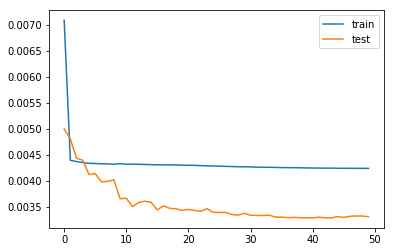

In [40]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [47]:
# make a prediction
yhat = model.predict(train_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

IndexError: tuple index out of range

In [51]:
yhat = model.predict(train_X)
print yhat

[[0.5064726 ]
 [0.50644815]
 [0.5064237 ]
 ...
 [0.45573643]
 [0.45987517]
 [0.46870095]]


In [52]:
numpy.savetxt("output.csv", yhat)

In [53]:
data2 = pd.read_csv('alone_together.txt', sep=" ", header=None)

In [54]:
dataset = data2
values = dataset.values
encoder = LabelEncoder()
values[0] = encoder.fit_transform(values[0])
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())

   var1(t-1)   var1(t)
1   0.477152  0.494751
2   0.494751  0.492393
3   0.492393  0.490262
4   0.490262  0.489571
5   0.489571  0.488990


In [55]:
# split into train and test sets 90-10
values = reframed.values
n_train = 0
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((0, 1, 1), (0,), (2111792, 1, 1), (2111792,))


In [56]:
yhat = model.predict(test_X)

In [58]:
numpy.savetxt("output2.csv", yhat)